# Personal Information
Name: **Your Name**

StudentID: **Your Student ID**

Email: [**youremail@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **DD.MM.YYYY**

# Data Context

Where is the data from & its domain
Used in different research already -> maybe cite some papers
Context of the data, goal
About DICOM
Explain that the data is already formatted by others before -> so no augmentation needed, no strange values
I files and O files


# Data Description

In [57]:
#Imports
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import re
from pydicom import dcmread
import hdf5storage
from mat4py import savemat
from IPython.display import Image
import cv2

### Data Loading
Here the dataset is loaded and all .mat files are saved as pictures(in png. format) of both the input(scan) and the output(coordinates) in a single image in the correct folder. 

- load_coordinates: reads the coordinates in the output files for all three segmentations(Outer, Inner with papillary muscle and inner without papillary muscle).
- plot_image_with_coordinates: checks the coordinates, normalizes them by dividing by 255. The reason for this is ... Later maybe a better method for normalization will be found. An output image will be plotted with the three lines for segmentation. The visual of the image is shown in the Analysis part.
- The last cell contains the code that runs through all the data and gives the DICOM image from the tframe.


In [14]:
def load_coordinates(output_file_path, index):
    try:
        output_data = sio.loadmat(output_file_path)
        coordinates_iwp = output_data['output']['Inner_with_Papillary_Muscles'][0, index]
        coordinates_iwop = output_data['output']['Inner_without_Papillary_Muscles'][0, index]
        coordinates_out = output_data['output']['Outer'][0, index]
        return coordinates_iwp, coordinates_iwop, coordinates_out
    except IndexError:
        return None, None, None

In [18]:
def plot_image_with_coordinates(input_image, coordinates_iwp, coordinates_iwop, coordinates_out, image_width,
                                image_height, save_path, filename, index):
    if coordinates_iwp is None or coordinates_iwop is None or coordinates_out is None:
        return
    for nested_coordinates_iwp, nested_coordinates_iwop, nested_coordinates_out in zip(coordinates_iwp[0],
                                                                                       coordinates_iwop[0],
                                                                                       coordinates_out[0]):
        scaled_coordinates_iwp = nested_coordinates_iwp * np.array([image_width / 255, image_height / 255])
        scaled_coordinates_iwop = nested_coordinates_iwop * np.array([image_width / 255, image_height / 255])
        scaled_coordinates_out = nested_coordinates_out * np.array([image_width / 255, image_height / 255])

        plt.imshow(input_image, cmap='gray')
        plt.plot(scaled_coordinates_iwp[:, 0], scaled_coordinates_iwp[:, 1], c='red', marker='.',
                 label='Inner with Papillary Muscles')
        plt.plot(scaled_coordinates_iwop[:, 0], scaled_coordinates_iwop[:, 1], c='blue', marker='.',
                 label='Inner without Papillary Muscles')
        plt.plot(scaled_coordinates_out[:, 0], scaled_coordinates_out[:, 1], c='green', marker='.',
                 label='Outer contour')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Input Image with Coordinates on top - ' + filename + '_' + str(index))
        plt.legend()
        plt.savefig(os.path.join(save_path, filename + '_' + str(index) + '.png'))
        plt.close()
    

In [19]:
for filename in os.listdir(input_folder_path):
    if re.match(r"I\d+\.mat", filename):
        input_file_path = os.path.join(input_folder_path, filename)
        output_file_path = os.path.join(input_folder_path, "O" + filename[1:])  # Matching output file name
        data = sio.loadmat(input_file_path)
        I_header = data['I']
        tframe_data = I_header['tframe'][0][0]
        file_number = filename[1:-4]
        for j, dicom_data in enumerate(tframe_data['dicom'][0], start=0):
            #imsave('image.png', dicom_data, cmap='gray') #ONLY RUN THIS WHEN NEEDED/FIRST TIME RUNNING -> TAKES A LONG TIME
            input_image_path = 'image.png'
            input_image = imread(input_image_path)
            image_height, image_width = input_image.shape[:2]
            coordinates_iwp, coordinates_iwop, coordinates_out = load_coordinates(output_file_path, j)
            plot_image_with_coordinates(input_image, coordinates_iwp, coordinates_iwop, coordinates_out, image_width,
                                        image_height, output_folder_path, 'image_I' + file_number, j)
     

In [12]:
# Input paths Cynthia
#input_folder_path = r"/mnt/c/Users/cinth/Documentos/ams/data_science/actual_thesis/codes/UniverSeg-main/UniverSeg-main/example_data/Training/"
#output_folder_path = r"/mnt/c/Users/cinth/Documentos/ams/data_science/actual_thesis/codes/UniverSeg-main/UniverSeg-main/example_data/Training/results"
# Input paths Eveline
input_folder_path = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\UniverSeg-eda\\UniverSeg-main\\example_data\\Training\\"
output_folder_path = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\UniverSeg-eda\\UniverSeg-main\\example_data\\Training\\results"

### Analysis 1:
In this analysis the number of images for each I file is checked in order to know more about the shape of the data. This is only for the training data.

In [49]:
data = []
for i in range(1, 17):
    filename = f'I{i}.mat'
    f = sio.loadmat(filename)
    D = f['I']
    tframe = D['tframe']
    Iref = tframe[0,0]
    x, y = Iref.shape
    data.append({'number_of_images': y})
df_shape = pd.DataFrame(data, index=['I{}'.format(i) for i in range(1, 17)])
df_shape

,number_of_images
I1,90
I2,109
I3,106
I4,126
I5,85
I6,103
I7,87
I8,66
I9,55
I10,99


The total number of images we have in our Training set is :

In [62]:
print(df_shape['number_of_images'].sum())

1445


Since the images itself need to be processed in the future, all images per input file (I) are stored as .mat file in a seperate folder. 

In [60]:
width = 256
height = 256
dim = (width, height)
count=1

for i in range(1, 17):
    os.chdir(input_folder_path)
    filename = f'I{i}.mat'
    f = sio.loadmat(filename)
    D = f['I']
    tframe = D['tframe']
    Iref = tframe[0,0]
    x, y = Iref.shape
    
    for j in range(y):
        image_path="C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\UniverSeg-eda\\UniverSeg-main\\example_data\\Training\\input_images"
        os.chdir(image_path)
        I = Iref[0, j]
        I1 = np.asarray(I[0])
        U = cv2.resize(I1, dim, interpolation=cv2.INTER_AREA)
        fsave = 'Image' + str(count).zfill(5) + '.mat'
        sio.savemat(fsave, {'U': U})
        count += 1
        

### Analysis 2: 
In this analysis the data is visualised to get a better understanding. Firstly we see the imput image in greyscale. All images are of the same medical domain and look similar to the one shown below. After running the code above all three segmentation lines are printed, made by coordinates in the O(output) files, on top of the input image. Shown are examples for two different dogs.

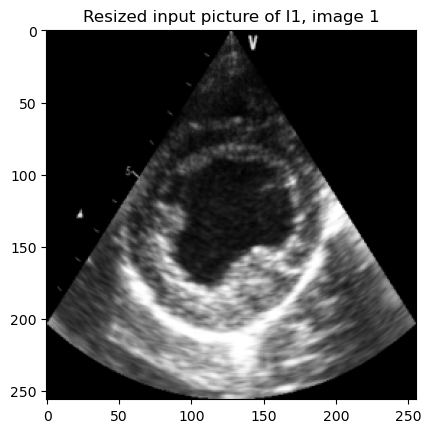

In [66]:
#Input Dog 1, image 1
I1_1 = sio.loadmat('Image00001.mat')
I1_1resized = I1_1['U']
plt.title('Resized input picture of I1, image 1')
plt.imshow(I1_1resized, cmap="gray") 

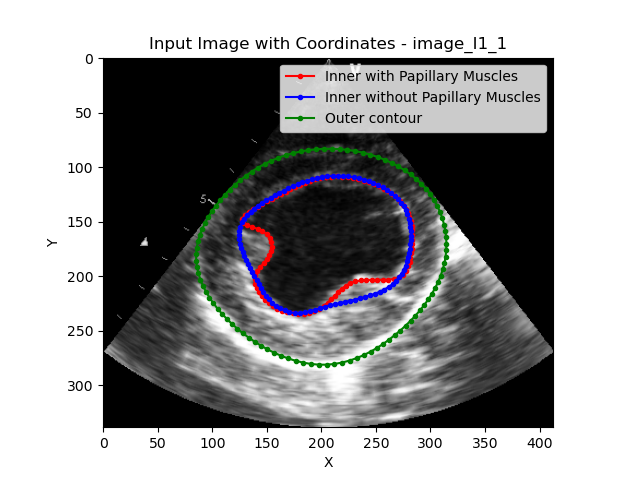

In [26]:
#Dog I1, image 1
Image(filename='C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\UniverSeg-eda\\UniverSeg-main\\example_data\\Training\\results\\image_I1_1.png',width=800, height=400)

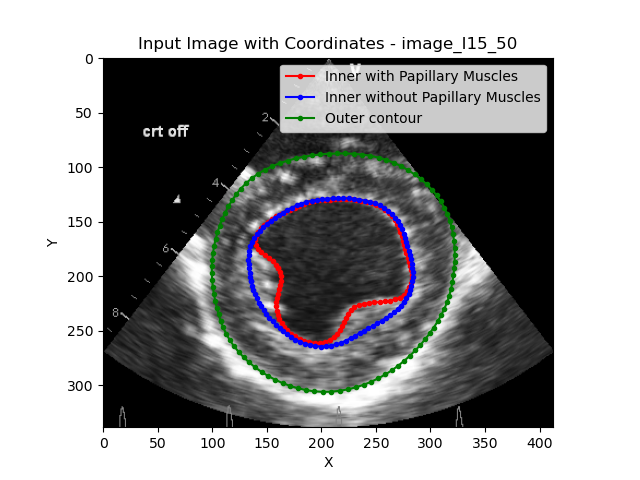

In [25]:
#Dog 15, image 50
Image(filename='C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\UniverSeg-eda\\UniverSeg-main\\example_data\\Training\\results\\image_I15_50.png',width=800, height=400)

### Analysis 2: 
Data shapes of Training, test and validation
 - For Training we have 16 I and O .mat files
 - For both Test abd Validation we have 5 I and O .mat files

### Analysis 3:
Number of images and check for for duplicates.
Check for duplicates in training/test/ validation (should not be any)

In [ ]:
# number of images -> Run over all I -> print(Nframes) -> store in df[I, Numberofimages]


### Analysis 4: 
Image Id and encoded pixels

### Analysis 5:
Select area of segmentation

### Analysis 6:
Run encoding

In [27]:
def encode_pixels_rle(image_shape, coordinates_iwp, coordinates_iwop, coordinates_out):
    """
    Encode pixel coordinates into a run-length encoded representation.
    
    Parameters:
    - image_shape: Shape of the image (height, width)
    - coordinates_iwp: List of coordinates for the inner wall of the prostate
    - coordinates_iwop: List of coordinates for the inner wall of the prostate outer perimeter
    - coordinates_out: List of coordinates for the outer wall of the prostate
    
    Returns:
    - rle_encoded: Run-length encoded representation of the segmented regions
    """
    # Initialize an empty list to store run-length encoded segments
    rle_encoded = []
    
    # Convert coordinates to binary mask
    binary_mask = np.zeros(image_shape, dtype=np.uint8)
    for coordinates in [coordinates_iwp, coordinates_iwop, coordinates_out]:
        for x, y in coordinates:
            binary_mask[y, x] = 1  # Note the reversal of x and y due to array indexing
    
    # Run-length encoding
    current_pixel_value = binary_mask[0, 0]
    run_length = 0
    for y in range(image_shape[0]):
        for x in range(image_shape[1]):
            pixel_value = binary_mask[y, x]
            if pixel_value == current_pixel_value:
                run_length += 1
            else:
                rle_encoded.append((current_pixel_value, run_length))
                current_pixel_value = pixel_value
                run_length = 1
    rle_encoded.append((current_pixel_value, run_length))  # Append last run-length
    
    return rle_encoded

### Analysis 7:
Check metadata

In [29]:
#input-> header -> Height, Width, Studydate, PatientSex
metadata_list = []
image_shape=(339,413) #NEEDS TO BE CHANGED
for filename in os.listdir(input_folder_path):
    if re.match(r"I\d+\.mat", filename):
        input_file_path = os.path.join(input_folder_path, filename)

        output_file_path = os.path.join(input_folder_path, "O" + filename[1:])  # Matching output file name
        data = sio.loadmat(input_file_path)
        I_header = data['I']
        tframe_data = I_header['tframe'][0][0]
        file_number = filename[1:-4]
        for j, dicom_data in enumerate(tframe_data['dicom'][0], start=0):
            coordinates_iwp, coordinates_iwop, coordinates_out = load_coordinates(output_file_path, j)
            #encoded_pixels = encode_pixels_rle(image_shape, coordinates_iwp, coordinates_iwop, coordinates_out)
            
            metadata = {
                'FileNumberI': file_number,
                'ImageIndex': j,
                'Sex' :
                'Studydate':
                #'EncodedPixels': encoded_pixels,
               
            }
            metadata_list.append(metadata)

# Convert metadata list to DataFrame
metadata_df = pd.DataFrame(metadata_list)
metadata_df.head(20)


,FileNumber,ImageIndex,FilePath
0,1,0,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
1,1,1,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
2,1,2,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
3,1,3,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
4,1,4,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
5,1,5,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
6,1,6,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
7,1,7,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
8,1,8,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...
9,1,9,C:\Users\eveli\OneDrive\Documenten\GitHub\Univ...


### Analysis 8: